# consistency regularization
- unlabeled data points still belong to the same category as perturbated versions of themselves
- regularizer $\lambda ||f(x) - f(x_{augmented}||^2_2$ forces the model to predict similar outputs for $x$ and $x_{augmented}$ 

notes:
- only few training epochs and data points were used to speed up the training
- only accuracy on labeled data points is considered for evaluation (including early stopping)

to ensure that the same data points are considered to be labeled across all epochs:
- data loaders fetch data points in sequential order and form batches from them
- the first `batch_size_unlabeled` $\in \{1, 2, ..., 100\} \cdot c$ data points in a batch are considered to be unlabeled
- the last `batch_size_labeled` $\in \{1, 2, ..., 100\} \cdot c$ data points in a batch are considered to be labeled
- `batch_size` $=$ `batch_size_labeled` + `batch_size_unlabeled` $=100\cdot c$
- all batches in the training loader are of same size

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
import sys
import subprocess

import torch
from torchvision import transforms, datasets
from torch.utils.data import random_split, SequentialSampler
from torch.optim import Adam
import matplotlib.pyplot as plt

subprocess.check_call([sys.executable, "-m", "pip", "install", "milankalkenings==0.1.39"])
from milankalkenings import *

In [127]:
class SemiSupervisedClassifier(Module):
    def __init__(self,
                 batch_size_unlabeled: int,
                 unlabeled_variations: int,
                 trans_unlabeled: transforms.Compose,
                 consistency_regul_strength: float,
                 cross_entropy_strength: float, 
                 device: str):
        super(SemiSupervisedClassifier, self).__init__()
        self.trans_unlabeled = trans_unlabeled
        self.unlabeled_variations = unlabeled_variations
        self.batch_size_unlabeled = batch_size_unlabeled
        self.consistency_regul_strength = consistency_regul_strength
        self.cross_entropy_strength = cross_entropy_strength
        self.device = device

        self.ce_loss = nn.CrossEntropyLoss()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=2),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=2),
                                        nn.ReLU(),
                                        nn.Flatten(),
                                        nn.Linear(in_features=512, out_features=10))

    @staticmethod
    def consistency_regul(scores1: torch.Tensor, scores2: torch.Tensor):
        return torch.norm(input=scores1 - scores2, p="fro") ** 2

    def consistency_regul_pairwise(self, x_unlabeled_augmented: List[torch.Tensor]) -> torch.Tensor:
        comparisons = 0
        con_regul = torch.zeros(size=[1]).to(self.device)
        for obs in range(self.batch_size_unlabeled):
            for var1 in range(self.unlabeled_variations):
                for var2 in range(self.unlabeled_variations):
                    if var1 < var2:  # only pairs that have not been compared (and no self-comparison)
                        scores1 = self.classifier(torch.unsqueeze(input=x_unlabeled_augmented[obs][var1], dim=0).to(self.device))
                        scores2 = self.classifier(torch.unsqueeze(input=x_unlabeled_augmented[obs][var2], dim=0).to(self.device))
                        con_regul += self.consistency_regul(scores1=scores1, scores2=scores2)
                        comparisons += 1
        return con_regul / comparisons  # so that the batch size doesn't have an influence

    def augment_unlabeled(self, x_unlabeled: torch.Tensor) -> List[torch.Tensor]:
        # create unlabeled_variations many variations per unlabeled data point
        x_unlabeled_augmented = []  # each entry holds variations of the same unlabeled data point
        for i in range(len(x_unlabeled)):
            variations = []
            for _ in range(self.unlabeled_variations):
                variations.append(torch.unsqueeze(input=self.trans_unlabeled(x_unlabeled[i]), dim=0))
            x_unlabeled_augmented.append(torch.cat(variations))
        return x_unlabeled_augmented

    def forward(self,
                x: Union[torch.Tensor, List[torch.Tensor]],
                y: Union[torch.Tensor, List[torch.Tensor]]) -> ModuleOutput:

        if self.training:
            loss = 0
            # supervised
            x_labeled = x[self.batch_size_unlabeled:]
            y_labeled = y[self.batch_size_unlabeled:]
            scores_labeled = self.classifier(x_labeled)
            loss = loss + self.cross_entropy_strength * self.ce_loss(input=scores_labeled, target=y_labeled)

            # unsupervised
            if (self.batch_size_unlabeled > 0) and (self.consistency_regul_strength > 0):
                x_unlabeled = x[:self.batch_size_unlabeled]
                x_unlabeled_augmented = self.augment_unlabeled(x_unlabeled=x_unlabeled)
                con_regul = self.consistency_regul_pairwise(x_unlabeled_augmented=x_unlabeled_augmented)
                loss = loss + self.consistency_regul_strength * con_regul
        else:  # during evaluation, the whole batch is treated to be labeled
            scores_labeled = self.classifier(x)
            loss = self.ce_loss(input=scores_labeled, target=y)
        return {"loss": loss, "scores": scores_labeled}


def check_loader(loader, name: str) -> None:
    n_batches = len(loader)
    first_batch = next(iter(loader))
    last_batch = None
    for i, batch in enumerate(loader):
        if i == (n_batches - 1):
            last_batch = batch
    print(name)
    print("batches:", n_batches)
    print("batch x shape:", first_batch[0].shape)
    print("batch y shape:", first_batch[1].shape)
    print("last x shape:", last_batch[0].shape)
    print("last batch y shape:", last_batch[1].shape)

In [128]:
# paths
data_path = "/content/drive/MyDrive/consistency_regularization/data"
monitoring_path = "/content/drive/MyDrive/consistency_regularization/monitoring"
checkpoint_initial = monitoring_path + "/checkpoint_initial.pkl"
checkpoint_running = monitoring_path + "/checkpoint_running.pkl"
checkpoint_final = monitoring_path + "/checkpoint_final.pkl"

# semi supervised training
device = "cuda"
n_epochs = 20
early_stopping_max_violations = 5
lr = 0.0005
consistency_regul_strength = 1  # == lambda
cross_entropy_strength = 1
unlabeled_variations = 2

# batch size
n_batches_train = 3
batch_size_scale = 7
n_train_val_obs = batch_size_scale * 125 * n_batches_train  
n_test_obs = batch_size_scale * 100 * n_batches_train

# augmentation
aug_brightness = 0.1
aug_contrast = 0.1
aug_saturation = 0.1
aug_hue = 0.1
trans_unlabeled = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=aug_brightness,
                                                             contrast=aug_contrast,
                                                             saturation=aug_saturation,
                                                             hue=aug_hue)])
trans_labeled = transforms.Compose([transforms.ToTensor()])

Files already downloaded and verified
Files already downloaded and verified
train loader
batches: 3
batch x shape: torch.Size([700, 3, 32, 32])
batch y shape: torch.Size([700])
last x shape: torch.Size([700, 3, 32, 32])
last batch y shape: torch.Size([700])
test accuracy: 0.32904762029647827 



test accuracy: 0.346190482378006 



test accuracy: 0.33619046211242676 



test accuracy: 0.3395237922668457 





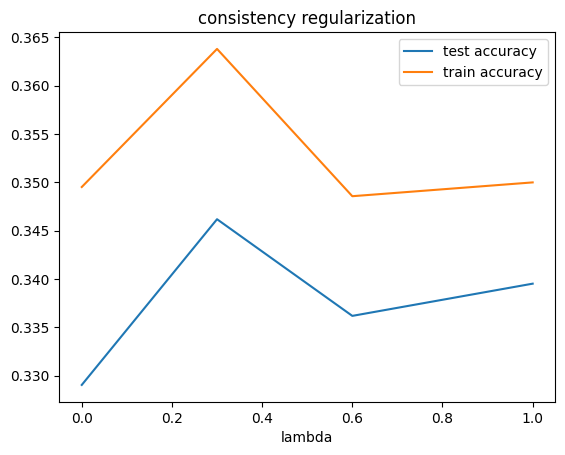

In [133]:
# plot over lambda: 0, 0.3, 0.6, 1
# 125 train_val_obs -> 100 train_obs -> batch_size_labeled and batch_size_unlabeled have to sum up to 100
batch_size_labeled = batch_size_scale * 90  
batch_size_unlabeled = batch_size_scale * 10
data = ImageClsDataset(dataset_class=datasets.CIFAR10,
                       save_dir=data_path + "/cifar10",
                       train_trans=trans_labeled,
                       val_trans=trans_labeled,
                       test_trans=trans_labeled, 
                       n_train_val_obs=n_train_val_obs, 
                       n_test_obs=n_test_obs)
loader_train, loader_val, loader_test = data.create_loaders(batch_size_train=batch_size_labeled + batch_size_unlabeled,
                                                            batch_size_val=batch_size_labeled + batch_size_unlabeled,
                                                            batch_size_test=batch_size_labeled + batch_size_unlabeled,
                                                            sequential_training_loader=True)

check_loader(loader=loader_train, name="train loader")

lambdas = [0, 0.3, 0.6, 1.0]  # 0 -> training only with cross entropy
test_accs = []
train_accs = []
for lam in lambdas:
    classifier = SemiSupervisedClassifier(batch_size_unlabeled=batch_size_unlabeled,
                                          unlabeled_variations=unlabeled_variations,
                                          trans_unlabeled=trans_unlabeled,
                                          consistency_regul_strength=lam,
                                          cross_entropy_strength=cross_entropy_strength, 
                                          device=device).to(device)
    trainer = Trainer(module=classifier,
                      loader_train=loader_train,
                      loader_val=loader_val,
                      loader_test=loader_test,
                      optimizer_class=Adam,
                      device=device,
                      checkpoint_running=checkpoint_running,
                      checkpoint_final=checkpoint_final)
    classifier, _, _ = trainer.train(n_epochs=n_epochs,
                                     lrs=[lr] * n_epochs,
                                     early_stopping_max_violations=early_stopping_max_violations, 
                                     printouts=False)
    test_accs.append(trainer.acc_epoch_eval(module=classifier, loader_eval=loader_test))
    train_accs.append(trainer.acc_epoch_eval(module=classifier, loader_eval=loader_train))
    print("test accuracy:", test_accs[-1], "\n\n\n")

plt.plot(lambdas, test_accs, label="test accuracy")
plt.plot(lambdas, train_accs, label="train accuracy")
plt.title("consistency regularization")
plt.xlabel("lambda")
plt.legend()
plt.savefig(monitoring_path + "/vary_lambda")

- using no consistency regularization (lambda = 0) leads to a worse result than using it (with any of the tested lambdas
- the result is best with lambda = 0.3
- choosing a hyperparameter like lambda is usually done on validation data, here on test data for simplicity
- the bigger lambda, the smaller the difference between train and test accuracy (that's why it is called a regularizer)

In [134]:
consistency_regul_strength = 0.3

# vary amount of labeled data

Files already downloaded and verified
Files already downloaded and verified
test accuracy: 0.3023809492588043 



Files already downloaded and verified
Files already downloaded and verified
test accuracy: 0.32428571581840515 



Files already downloaded and verified
Files already downloaded and verified
test accuracy: 0.32380953431129456 





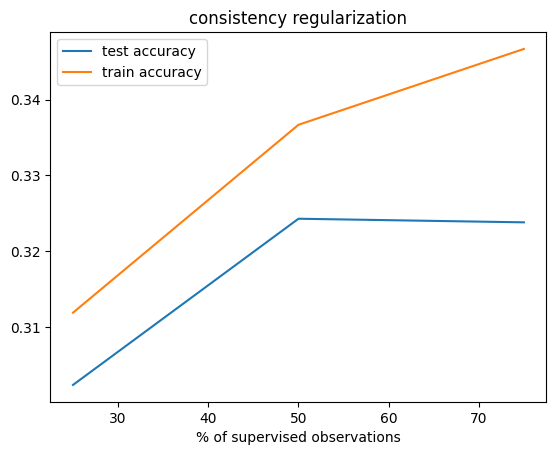

In [135]:
# plot over fixed (best) lambda and percentage of labeled observations: 25%, 50% 75%

amounts_labeled = [25, 50, 75]

train_accs = []
test_accs = []
for amount_labeled in amounts_labeled:
    batch_size_labeled = batch_size_scale * amount_labeled  
    batch_size_unlabeled = batch_size_scale * (100 - amount_labeled)

    # data loaders
    data = ImageClsDataset(dataset_class=datasets.CIFAR10,
                           save_dir=data_path + "/cifar10",
                           train_trans=trans_labeled,
                           val_trans=trans_labeled,
                           test_trans=trans_labeled, 
                           n_train_val_obs=n_train_val_obs, 
                           n_test_obs=n_test_obs)
    loader_train, loader_val, loader_test = data.create_loaders(batch_size_train=batch_size_labeled + batch_size_unlabeled,
                                                                batch_size_val=batch_size_labeled + batch_size_unlabeled,
                                                                batch_size_test=batch_size_labeled + batch_size_unlabeled,
                                                                sequential_training_loader=True)

    classifier = SemiSupervisedClassifier(batch_size_unlabeled=batch_size_unlabeled,
                                          unlabeled_variations=unlabeled_variations,
                                          trans_unlabeled=trans_unlabeled,
                                          consistency_regul_strength=consistency_regul_strength,
                                          cross_entropy_strength=cross_entropy_strength, 
                                          device=device).to(device)
    trainer = Trainer(module=classifier,
                      loader_train=loader_train,
                      loader_val=loader_val,
                      loader_test=loader_test,
                      optimizer_class=Adam,
                      device=device,
                      checkpoint_running=checkpoint_running,
                      checkpoint_final=checkpoint_final)
    classifier, _, _ = trainer.train(n_epochs=n_epochs,
                                     lrs=[lr] * n_epochs,
                                     early_stopping_max_violations=early_stopping_max_violations, 
                                     printouts=False)
    train_accs.append(trainer.acc_epoch_eval(module=classifier, loader_eval=loader_train))
    test_accs.append(trainer.acc_epoch_eval(module=classifier, loader_eval=loader_test))
    print("test accuracy:", test_accs[-1], "\n\n\n")

plt.plot(amounts_labeled, test_accs, label="test accuracy")
plt.plot(amounts_labeled, train_accs, label="train accuracy")
plt.title("consistency regularization")
plt.xlabel("% of supervised observations")
plt.legend()
plt.savefig(monitoring_path + "/vary_labeled")

- only 25% labeled observations already lead to a (relatively) good result
- test accuracy grows strongly underlinearly with increased amount of supervised observations